Project: Predict Churn Rate with Random Forest

Dataset: Olist (kaggle)

Goal:
- Dự đoán khả năng khách hàng rời bỏ (churn) dựa trên hành vi mua hàng, điểm đánh giá và phương thức thanh toán.

- Xây dựng mô hình học máy (Random Forest).

- Đánh giá độ chính xác và khả năng phân biệt (ROC-AUC).

# Import library

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, roc_auc_score, classification_report, confusion_matrix
)
from joblib import dump

# Load data

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [5]:
!kaggle datasets download -d olistbr/brazilian-ecommerce


Dataset URL: https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce
License(s): CC-BY-NC-SA-4.0
  0% 0.00/42.6M [00:00<?, ?B/s]
100% 42.6M/42.6M [00:00<00:00, 1.47GB/s]


In [6]:
!unzip brazilian-ecommerce.zip


Archive:  brazilian-ecommerce.zip
  inflating: olist_customers_dataset.csv  
  inflating: olist_geolocation_dataset.csv  
  inflating: olist_order_items_dataset.csv  
  inflating: olist_order_payments_dataset.csv  
  inflating: olist_order_reviews_dataset.csv  
  inflating: olist_orders_dataset.csv  
  inflating: olist_products_dataset.csv  
  inflating: olist_sellers_dataset.csv  
  inflating: product_category_name_translation.csv  


In [7]:
orders = pd.read_csv('olist_orders_dataset.csv')
reviews = pd.read_csv('olist_order_reviews_dataset.csv')
items = pd.read_csv('olist_order_items_dataset.csv')
customers = pd.read_csv('olist_customers_dataset.csv')
payments = pd.read_csv('olist_order_payments_dataset.csv')


# data preparation


In [8]:
orders = orders[orders['order_status'] == 'delivered'].copy()


In [9]:
df = orders.merge(items, on='order_id', how='inner')

df = df.merge(reviews[['order_id', 'review_score']], on='order_id', how='left')

df = df.merge(payments[['order_id', 'payment_type', 'payment_value', 'payment_installments']], on='order_id', how='left')

df = df.merge(customers[['customer_id', 'customer_unique_id']], on='customer_id', how='left')

In [10]:
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'])
df['order_estimated_delivery_date'] = pd.to_datetime(df['order_estimated_delivery_date'])

df['delivery_time'] = (df['order_delivered_customer_date'] - df['order_purchase_timestamp']).dt.days
df['delivery_delay'] = (df['order_delivered_customer_date'] - df['order_estimated_delivery_date']).dt.days


## Data cleaning

In [13]:
# Kiểm tra null

df.isnull().sum().sort_values(ascending=False)


,0
order_id,0
customer_id,0
order_status,0
order_purchase_timestamp,0
order_approved_at,0
order_delivered_carrier_date,0
order_delivered_customer_date,0
order_estimated_delivery_date,0
order_item_id,0
product_id,0


In [12]:
# Drop null
df = df.dropna().reset_index(drop=True)

## Feature engineering

In [14]:
# 1️⃣ Cột 1/0 cho khách dùng thẻ credit card trên từng đơn
df['is_credit_card'] = (df['payment_type'] == 'credit_card').astype(int)

features_df = df.groupby('customer_unique_id').agg(
    num_orders=('order_id', 'nunique'),
    avg_order_value=('payment_value', 'mean'),
    total_spent=('payment_value', 'sum'),
    avg_delivery_time=('delivery_time', 'mean'),
    avg_delivery_delay=('delivery_delay', 'mean'),
    avg_review_score=('review_score', 'mean'),
    num_low_reviews=('review_score', lambda x: (x <= 2).sum()),
    num_high_reviews=('review_score', lambda x: (x >= 4).sum()),
    avg_freight_value=('freight_value', 'mean'),
    avg_payment_installments=('payment_installments', 'mean'),
    payment_type_credit_card=('is_credit_card', 'max')
).reset_index()



In [15]:
# Xác định ngày cuối cùng
cutoff_date = df['order_purchase_timestamp'].max()

# Tính ngày mua cuối của mỗi khách hàng
last_purchase = df.groupby('customer_unique_id')['order_purchase_timestamp'].max().reset_index()
last_purchase.columns = ['customer_unique_id', 'last_purchase_date']

# Tính số ngày kể từ lần mua cuối
last_purchase['days_since_last_purchase'] = (cutoff_date - last_purchase['last_purchase_date']).dt.days

# Gán nhãn churn (1 = churn, 0 = active)
last_purchase['churn'] = np.where(last_purchase['days_since_last_purchase'] > 180, 1, 0)

features_df = features_df.merge(last_purchase[['customer_unique_id', 'churn']],
                                on='customer_unique_id', how='left')


# Xây dựng mô hình

## Training

In [18]:
# Chia train/test

X = features_df.drop(columns=['customer_unique_id', 'churn'])
y = features_df['churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [19]:
# Chuẩn hóa feature

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [23]:
# Mô hình Random Forest

rf = RandomForestClassifier(random_state=0, class_weight='balanced')

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30 ],
}

# Tối ưu siêu tham số (Grid search)
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc',
)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best CV ROC-AUC:", grid_search.best_score_)



Best parameters: {'max_depth': 30, 'n_estimators': 300}
Best CV ROC-AUC: 0.8844497600743754


## Evaluation

In [24]:
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)
y_proba = best_rf.predict_proba(X_test)[:, 1]

from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))

Accuracy: 0.8105893136356284
ROC-AUC: 0.89087542231126
              precision    recall  f1-score   support

           0       0.81      0.70      0.75      7629
           1       0.81      0.89      0.85     10918

    accuracy                           0.81     18547
   macro avg       0.81      0.79      0.80     18547
weighted avg       0.81      0.81      0.81     18547



## Top Feature Importance

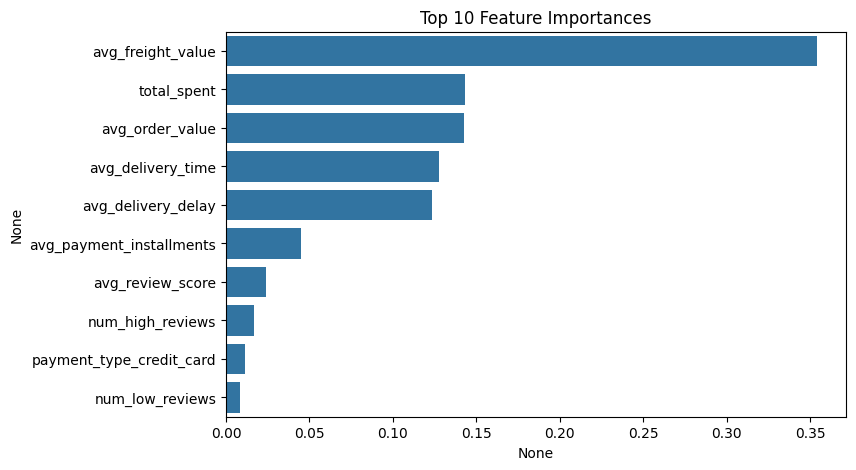

In [25]:
importances = pd.Series(best_rf.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(8,5))
sns.barplot(x=importances.head(10), y=importances.head(10).index)
plt.title("Top 10 Feature Importances")
plt.show()


# Save model and scaler

In [26]:
dump(best_rf, 'random_forest_churn_model.pkl')
dump(scaler, 'scaler.pkl')
print("Model and scaler saved successfully.")

Model and scaler saved successfully.
